In [1]:
import requests

def getCSV( code, year ):     # 株価情報ファイルをダウンロードする関数
    try:
        response = requests.post(
            'https://hogehoge/hogehoge/hogehoge', 
            data = { 'code': str(code), 'year': str(year) },
            headers={ 'referer':  'https://hogehoge/hogehoge',
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100",
                "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8"
            } )
        if ( ',,,,,' in response.text ): # レスポンス内容から、CSVをダウンロードできたか確認
            return True, response.text
        else:
            return False, ''
    except:
        print( 'An error caused.')
    return False, 'error'

In [2]:
# pd.read_excel を使うためには
# conda install xlwt
# conda install openpyxl

# ダウンロードされたCSVファイルを読み込む関数
# その内容は、
# stock: 銘柄情報（東証エクセルファイルからの情報）
# values: 刻々の株価情報
# のリスト

# 東証上場銘柄一覧（2019年9月末）を読み込み、CSVファイルをダウンロードしておく
# https://www.jpx.co.jp/markets/statistics-equities/misc/01.html

import numpy as np
import pandas as pd
import io, os, time
from datetime import datetime

isDownloaded = True; isDownloading = False
code_df = pd.read_excel('/Users/jun/data/data_j.xls'); data = []
for index, row in code_df.iterrows():
    if row[ '33業種コード' ] !=  '-': # if row[ '33業種コード' ] !=  '-'  and row[ 'コード' ] ==1332:
        code = row[ 'コード' ]; dfs = [] 
        for year in [year for year in range(1983, 2019+1)]:
            path = '/Volumes/dataDisk/stockprices_all/'+"{0}_{1}.csv".format( code, year )
            if isDownloaded:              # ダウンロード済みの場合
                if os.path.isfile( path ): # ファイルがあれば DataFrame 作成
                    df = pd.read_csv( path, sep=",",  header=1, encoding="shift-jis" )
                    for col in [ '始値', '高値', '安値', '終値', '出来高', '終値調整値' ]:
                        df[ col ] = df[ col ].astype( float )
                    df['日付'] = [ datetime.strptime( date, '%Y-%m-%d') for date in df[ '日付' ]]
                    dfs.append( df )
            if isDownloading: # ダウンロード時
                time.sleep( 2 );print( '{} : {}'.format( code, year ) ) 
                status, csv = getCSV( code, year ) # CSVデータを取得
                if status:
                    with open( path, "w", encoding='shift_jis') as fileobj:
                        fileobj.write( csv ) # CSVファイルを保存
        if isDownloaded:
            if len( dfs ) > 0:
                    values = ( pd.concat( dfs, axis=0 ) ).reset_index( drop=True )
                    data.append( { 'stock': row, 'values': values } )

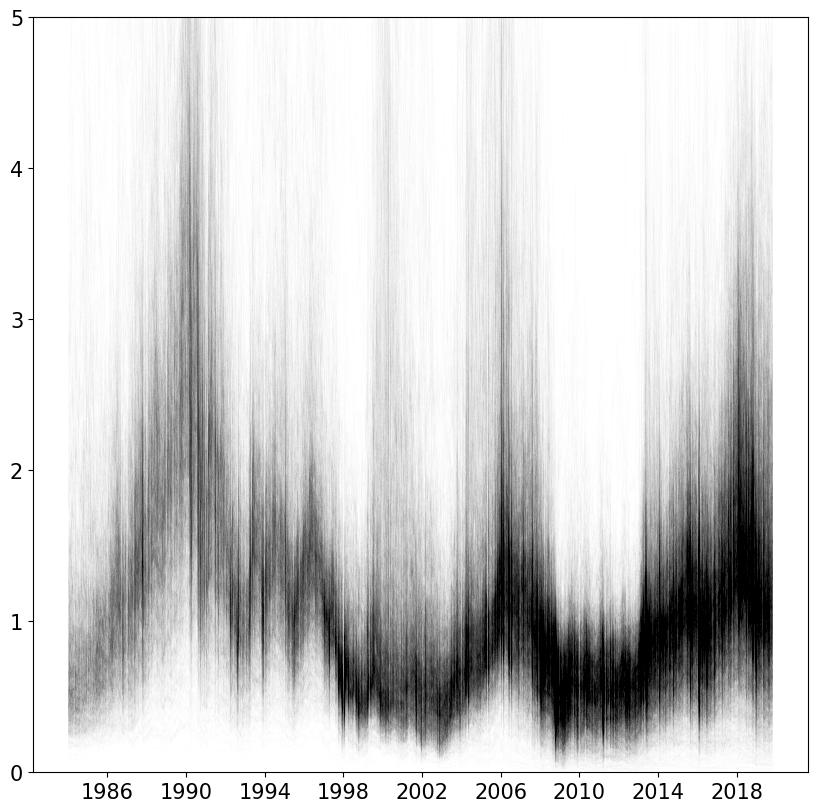

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["font.size"] = 15
plt.figure( figsize=( 10, 10 ), dpi=100 )
plt.ylim( [0,5] )
for datum in data:
    df = datum['values'][(datum['values']['日付'] >= datetime(1984,1,1)) & (datum['values']['日付'] < datetime(2019,11,1))]    
    x = df["日付"]
    y = df["終値調整値"] / df["終値調整値"].mean()
    plt.plot(x, y, linewidth = 0.0015, color='black')

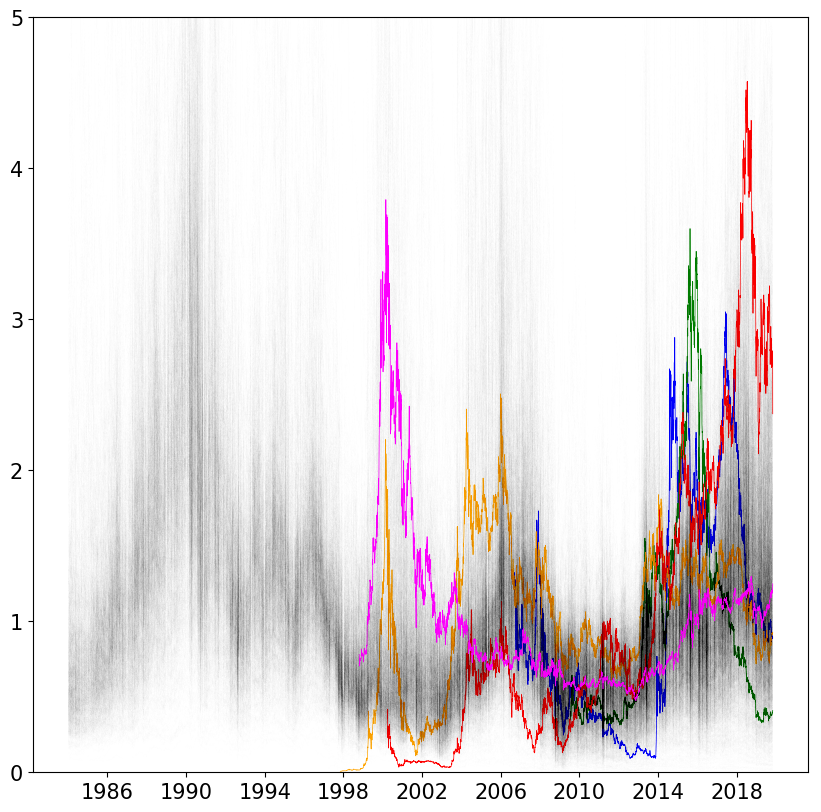

In [6]:
plt.rcParams["font.size"] = 15
plt.figure( figsize=( 10, 10 ), dpi=100 )
plt.ylim( [0,5] )
for datum in data:
        df = datum['values'][(datum['values']['日付'] >= datetime(1984,1,1)) & (datum['values']['日付'] < datetime(2019,11,1))]    
        x = df["日付"]
        y = df["終値調整値"] / df["終値調整値"].mean()
        if datum['stock']['銘柄名'] == 'サイバーエージェント':
            plt.plot(x, y, linewidth = 0.5, color='red')
        elif datum['stock']['銘柄名'] == 'ミクシィ':
            plt.plot(x, y, linewidth = 0.5, color='blue')
        elif datum['stock']['銘柄名'] == 'クックパッド':
            plt.plot(x, y, linewidth = 0.5, color='green')
        elif datum['stock']['銘柄名'] == 'ヤフー':
            plt.plot(x, y, linewidth = 0.5, color='orange')
        elif datum['stock']['銘柄名'] == 'ＮＴＴドコモ':
            plt.plot(x, y, linewidth = 0.5, color='Magenta')
        else:
            plt.plot(x, y, linewidth = 0.0004, color='black')

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


<Figure size 500x500 with 0 Axes>

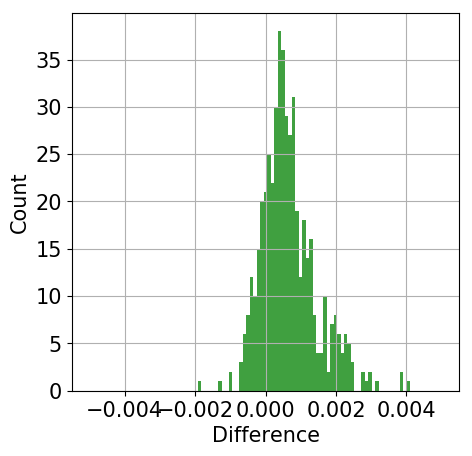

In [76]:
diff_days = []
diff_nights = []

for datum in data:
    if datum['stock']['規模区分'] == 'TOPIX Small 1':
        df = datum['values']
        x = (df["終値"][:-1].values - df["始値"][:-1].values) / df["始値"][:-1].values
        y = (df["始値"][1:].values - df["終値"][:-1].values) / df["終値"][:-1].values
        diff_days.append( x.mean() )
        diff_nights.append( y.mean() )


<Figure size 500x500 with 0 Axes>

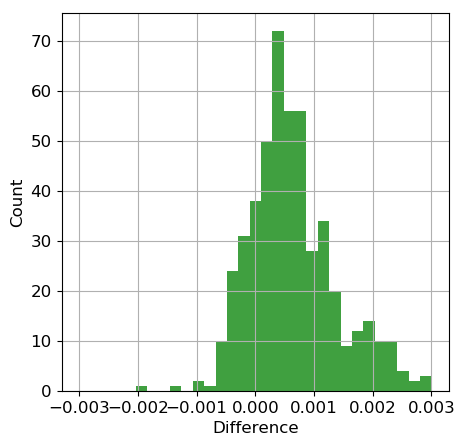

In [91]:
# 始値-終値の分布を描いてみる。
plt.rcParams["font.size"] = 12
plt.figure( figsize=( 5, 5 ), dpi=100 )
fig, ax = plt.subplots( figsize=(5, 5), dpi=100 )
plt.ylabel( 'Count'); plt.xlabel( 'Difference' )
ax.hist( diff_nights , bins=31, range=( -0.003, 0.003 ), 
            facecolor='green', alpha=0.75 )
ax.grid( True )


<Figure size 500x500 with 0 Axes>

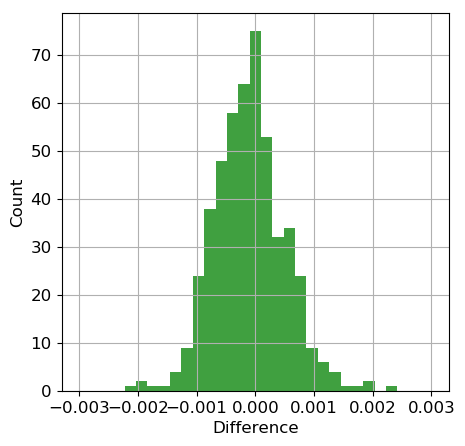

In [92]:
# 終値-始値の分布を描いてみる。
plt.rcParams["font.size"] = 12
plt.figure( figsize=( 5, 5 ), dpi=100 )
fig, ax = plt.subplots( figsize=(5, 5), dpi=100 )
plt.ylabel( 'Count'); plt.xlabel( 'Difference' )
ax.hist( diff_days , bins=31, range=( -0.003, 0.003 ), 
            facecolor='green', alpha=0.75 )
ax.grid( True )


493


<Figure size 500x500 with 0 Axes>

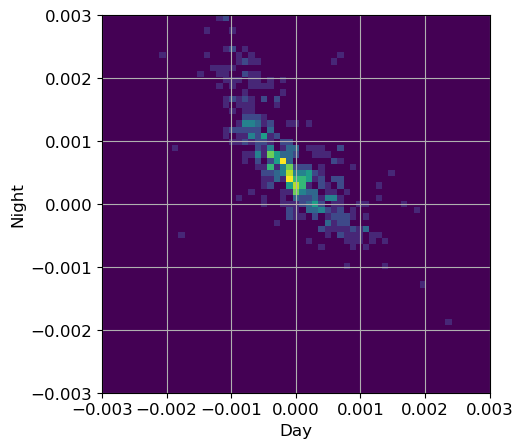

In [93]:
# 2次元散布図で眺めてみる
print( len(diff_days) )
plt.figure( figsize=( 5, 5 ), dpi=100 )
fig, ax = plt.subplots( figsize=(5, 5), dpi=100 )
plt.xlabel( 'Day' ); plt.ylabel( 'Night')
plt.xlim( [-0.004,0.004] ) 

ax.hist2d( diff_days , diff_nights , bins=[61,61], range=[[-0.003, 0.003], [-0.003, 0.003]],
         )#norm=mpl.colors.LogNorm() )
ax.grid( True )

#フィッティング直線を描く場合
# a, b = np.polyfit( diff_days, diff_nights, 1) # 1変数
# y_fit = a * np.array( diff_days ) + b
# ax.plot(diff_days, y_fit, lw=0.2, color='red')
# ax.text( -0.001, a*0.001+b, 'y='+ str(round(a,4)) +'x+'+str(round(b,4)), color='white')

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


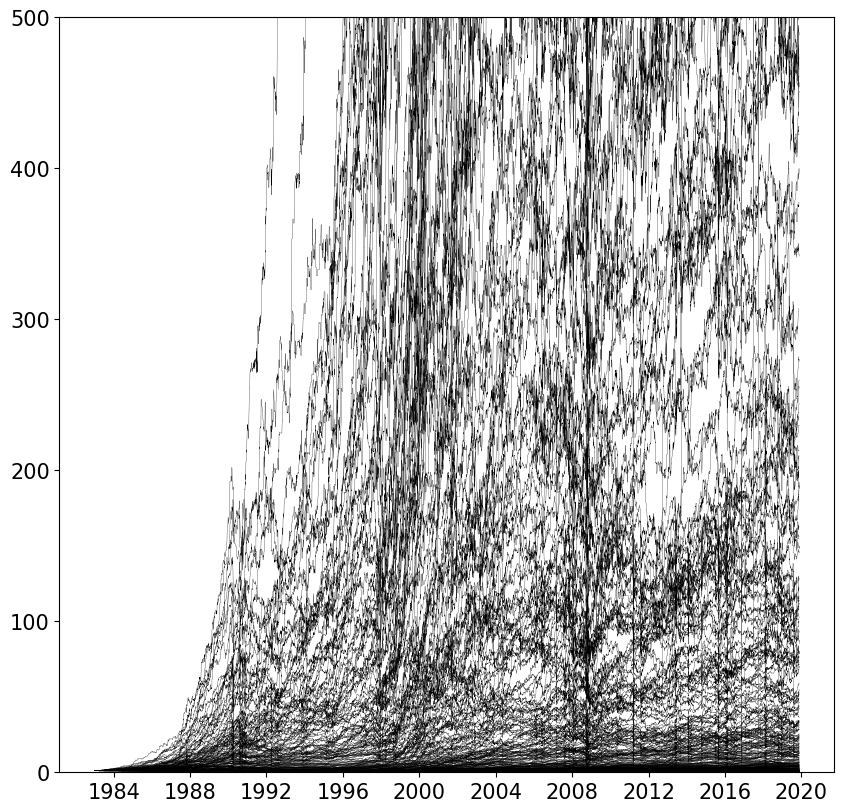

In [17]:
plt.rcParams["font.size"] = 15

trials = []
for datum in data:
    if datum['stock']['規模区分'] == 'TOPIX Small 1':
        val = pd.DataFrame([], columns=['日付', '累積乗積値'])
        df = datum['values']; isFirst = True
        for i in df.index.values:
            if isFirst:
                val = val.append( pd.DataFrame([ df['日付'][i], 1.0], index=val.columns).T )
                isFirst = False
            else:
                if (df["終値"][i-1] - df["始値"][i-1])/df["始値"][i-1] < -0.0005: # 前日の「朝→夕」で値下がりしていたら、
                    y = 1.0+(df["始値"][i] - df["終値"][i-1] ) / df["終値"][i-1] # 夜にかけて買って、朝売る
                    val = val.append( pd.DataFrame([ df['日付'][i], val.iloc[-1]['累積乗積値'] * y], index=val.columns).T )
                else: # そうでなければ、そのまま
                    val = val.append( pd.DataFrame([ df['日付'][i], val.iloc[-1]['累積乗積値']], index=val.columns).T )
        trials.append( {'time':val["日付"], 'val':val["累積乗積値"] } )

plt.figure( figsize=( 10, 10 ), dpi=100 ); plt.ylim( [0, 500] )
for trial in trials:
        plt.plot( trial['time'], trial['val'], linewidth = 0.2 , color='black')
plt.show()

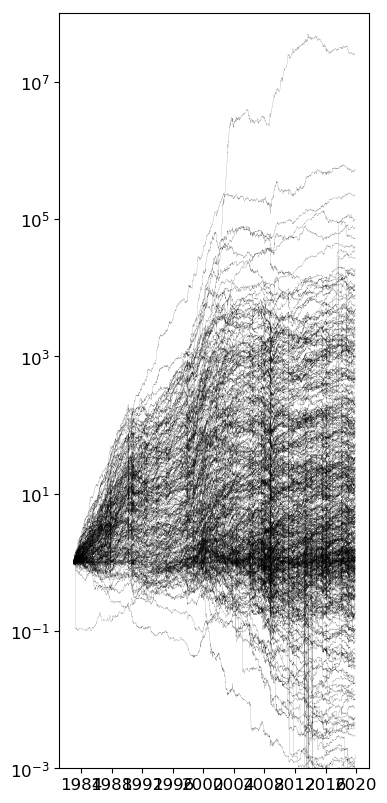

In [94]:
plt.figure( figsize=( 4, 10 ), dpi=100 ); plt.ylim( [1/1000, 100000000] )

plt.yscale('log')
for trial in trials:
        plt.plot( trial['time'], trial['val'], linewidth = 0.08 , color='black')

#plt.show()

55677.70487242281
3.9770710909109073


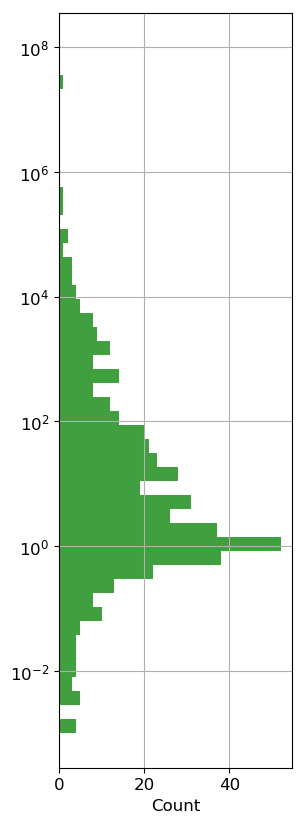

In [88]:
fig, ax = plt.subplots( figsize=(3, 10), dpi=100 )
plt.ylabel( ''); plt.xlabel( 'Count' )

results = []
for trial in trials:
    results.append( trial['val'].iloc[-1] )

print( np.mean( results ) )   # 平均値→55677.70487242281
print( np.median( results ) )   # 中央値→3.9770710909109073
ax.hist( results, bins=np.logspace( -3, 8, 50 ), 
            facecolor='green', alpha=0.75, orientation="horizontal")
ax.set_yscale('log'); ax.grid( True ); plt.show()